# **IMPORTADO DE MÓDULOS**

In [ ]:
import numpy as np
import numpy.matlib

import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
tf.version.VERSION

'2.15.0'

In [ ]:
from scipy.optimize import curve_fit
#https://gist.github.com/cpascual/a03d0d49ddd2c87d7e84b9f4ad2df466
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import initializers
from keras.regularizers import l2
from keras.losses import mse
import keras.backend as K

In [ ]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

# **INTERPOLACION**

In [ ]:
start = 50
stop = 80
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28[:,start:stop,:]
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28[:,start:stop,:],  kind='cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55[:,start:stop,:],  kind='cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82[:,start:stop,:],  kind='cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)

print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 50
Time step: 0.20
New number of time points: 400
New time step: 0.0250


# **NEURAL NETWORK**

In [ ]:
def model_definition(N_points):

  input_shape = (N_points,2,1)


  model = Sequential()
  model.add(Conv2D(filters=4, kernel_size=(2, 2), activation='relu', padding = 'same', input_shape=input_shape)) #ouput_dim = (N_points, 2, 16)
  model.add(Conv2D(filters=8, kernel_size=(2, 2), activation='relu', padding = 'same')) #ouput_dim = (N_points, 2, 32)
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(4, activation='relu'))
  model.add(Dense(1, activation='linear'))
  return model

In [ ]:
model = model_definition(Nt_new)

In [ ]:
model.compile(optimizer='adam',loss='MSE')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 400, 2, 4)         40        
                                                                 
 conv2d_13 (Conv2D)          (None, 400, 2, 8)         296       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 200, 1, 8)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 1600)              0         
                                                                 
 dense_12 (Dense)            (None, 4)                 6404      
                                                                 
 dense_13 (Dense)            (None, 1)                 5         
                                                      

In [ ]:
Ntrain_V55 = int(0.7*new_V55.shape[0])
Ntrain_V28 = int(0.7*new_V28.shape[0])
Ntrain_V82 = int(0.7*new_V82.shape[0])
train_data = np.concatenate((new_V55[0:Ntrain_V55,:,:],new_V28[0:Ntrain_V28,:,:],new_V82[0:Ntrain_V82,:,:]),axis = 0)
validation_data = np.concatenate((new_V55[Ntrain_V55:,:,:],new_V28[Ntrain_V28:,:,:],new_V82[Ntrain_V82:,:,:]),axis = 0)
REF = np.zeros(train_data.shape[0])
REF[0:Ntrain_V55] = 0
REF[Ntrain_V55:Ntrain_V55 + Ntrain_V28] = -0.2
REF[Ntrain_V55 + Ntrain_V28:] = 0.2

In [ ]:
history = model.fit(train_data, REF, epochs=50)

Epoch 1/50
17/17 [==============================] - 2s 14ms/step - loss: 0.0268
Epoch 2/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0251
Epoch 3/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0250
Epoch 4/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 5/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 6/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 7/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 8/50
17/17 [==============================] - 0s 3ms/step - loss: 0.0248
Epoch 9/50
17/17 [==============================] - 0s 3ms/step - loss: 0.0248
Epoch 10/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 11/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 12/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 13/50
17/17 [=============================

In [ ]:
TOF = model.predict(validation_data)

7/7 [==============================] - 0s 18ms/step


<ipython-input-2-1a74867061f5>:4: RuntimeWarning: divide by zero encountered in divide
  return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
<ipython-input-2-1a74867061f5>:4: RuntimeWarning: invalid value encountered in divide
  return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',



V82: CENTROID(ns) = 0.013  FWHM(ns) = 0.000  std(ns) = 0.000
V55: CENTROID(ns) = 0.013  FWHM(ns) = 0.000  std(ns) = 0.000
V28: CENTROID(ns) = 0.013  FWHM(ns) = 0.000  std(ns) = 0.000


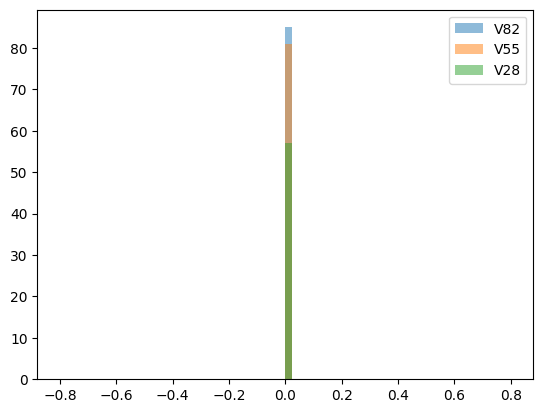

In [ ]:
Nval_V28 = new_V28[Ntrain_V28:,:,:].shape[0]
Nval_V55 = new_V55[Ntrain_V55:,:,:].shape[0]
Nval_V82 = new_V82[Ntrain_V82:,:,:].shape[0]
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=64
histogN_V82, binsN, patchesN  = plt.hist(TOF[Nval_V55 + Nval_V28:] - np.mean(TOF[0:Nval_V55]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOF[0:Nval_V55] - np.mean(TOF[0:Nval_V55]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOF[Nval_V55: Nval_V55 + Nval_V28] - np.mean(TOF[0:Nval_V55]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

# **DETECTOR 0**

In [ ]:
train_data = np.concatenate((new_V55,new_V28,new_V82),axis = 0)

## DATA CREATION


In [ ]:
Ncasos = train_data.shape[0]
INPUT_dec0 = np.zeros_like(train_data)
REF_dec0 = np.zeros((Ncasos,),dtype=np.float32)

NRD0 = np.random.randint(20, size=Ncasos)
NRD1 = np.random.randint(20, size=Ncasos)

for i in range(Ncasos):
  N0 = NRD0[i]
  noise0 = np.random.normal(scale=1e-3, size=N0)
  noise00 = np.random.normal(scale=0.01, size=INPUT_dec0.shape[1])
  smoothed_noise = gaussian_filter1d(noise00, sigma=10)
  INPUT_dec0[i,:,0]=np.roll(train_data[i,:,0],N0)
  INPUT_dec0[i,:,0] = INPUT_dec0[i,:,0] + smoothed_noise
  INPUT_dec0[i,0:N0,0] = noise0

  N1 = NRD1[i]
  noise1 = np.random.normal(scale=1e-3, size=N1)
  noise11 = np.random.normal(scale=0.01, size=INPUT_dec0.shape[1])
  smoothed_noise = gaussian_filter1d(noise11, sigma=10)
  INPUT_dec0[i,:,1]=np.roll(train_data[i,:,0],N1)
  INPUT_dec0[i,:,1] = INPUT_dec0[i,:,1] + smoothed_noise
  INPUT_dec0[i,0:N1,1] = noise1

  REF_dec0[i]=new_time_step*(N0-N1)  #in ns (t_shift is defined above)



trainX_dec0 = INPUT_dec0[:,:,:]
REF_train_dec0 = REF_dec0[:]

## NEURAL NETWORK

In [ ]:
model_dec0 = model_definition(Nt_new)

In [ ]:
opt = tf.keras.optimizers.AdamW(learning_rate=1e-4)
model_dec0.compile(optimizer=opt, loss = 'MSE')
model_dec0.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 400, 2, 4)         40        
                                                                 
 conv2d_19 (Conv2D)          (None, 400, 2, 8)         296       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 200, 1, 8)         0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 1600)              0         
                                                                 
 dense_18 (Dense)            (None, 4)                 6404      
                                                                 
 dense_19 (Dense)            (None, 1)                 5         
                                                      

In [ ]:
history_dec0 = model_dec0.fit(trainX_dec0, REF_train_dec0, epochs=50)

Epoch 1/50
19/19 [==============================] - 1s 12ms/step - loss: 0.0435 - val_loss: 0.0412
Epoch 2/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0430 - val_loss: 0.0412
Epoch 3/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0429 - val_loss: 0.0412
Epoch 4/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0428 - val_loss: 0.0412
Epoch 5/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0428 - val_loss: 0.0411
Epoch 6/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0427 - val_loss: 0.0411
Epoch 7/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0427 - val_loss: 0.0411
Epoch 8/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0427 - val_loss: 0.0411
Epoch 9/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0426 - val_loss: 0.0411
Epoch 10/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0426 - val_loss: 0.0410
Epoch 11/50
19/19 

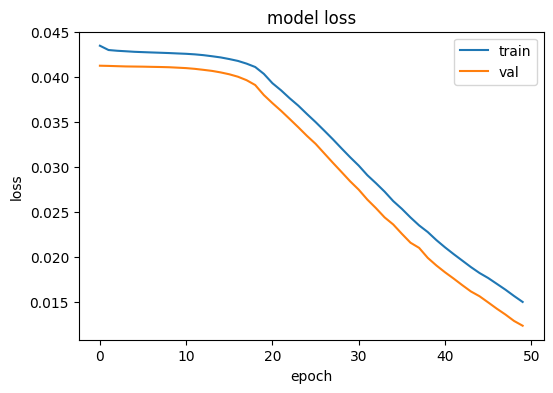

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history_dec0.history['loss'])
plt.plot(history_dec0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# **DETECTOR 1**

## DATA CREATION


In [ ]:
Ncasos = train_data.shape[0]
INPUT_dec1 = np.zeros_like(train_data)
REF_dec1 = np.zeros((Ncasos,),dtype=np.float32)

NRD0 = np.random.randint(20, size=Ncasos)
NRD1 = np.random.randint(20, size=Ncasos)

for i in range(Ncasos):
  N0 = NRD0[i]
  noise0 = np.random.normal(scale=1e-3, size=N0)
  noise00 = np.random.normal(scale=0.01, size=INPUT_dec1.shape[1])
  smoothed_noise = gaussian_filter1d(noise00, sigma=10)
  INPUT_dec1[i,:,0]=np.roll(train_data[i,:,1],N0)
  INPUT_dec1[i,:,0] = INPUT_dec1[i,:,0] + smoothed_noise
  INPUT_dec1[i,0:N0,0] = noise0

  N1 = NRD1[i]
  noise1 = np.random.normal(scale=1e-3, size=N1)
  noise11 = np.random.normal(scale=0.01, size=INPUT_dec1.shape[1])
  smoothed_noise = gaussian_filter1d(noise11, sigma=10)
  INPUT_dec1[i,:,1]=np.roll(train_data[i,:,1],N1)
  INPUT_dec1[i,:,1] = INPUT_dec1[i,:,1] + smoothed_noise
  INPUT_dec1[i,0:N1,1] = noise1

  REF_dec1[i]=new_time_step*(N0-N1)  #in ns (t_shift is defined above)



trainX_dec1 = INPUT_dec1[:,:,:]
REF_train_dec1 = REF_dec1[:]

## NEURAL NETWORK

In [ ]:
model_dec1 = model_definition(Nt_new)

In [ ]:
opt = tf.keras.optimizers.AdamW(learning_rate=1e-4)
model_dec1.compile(optimizer=opt, loss = 'MSE')
model_dec1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 400, 2, 4)         40        
                                                                 
 conv2d_21 (Conv2D)          (None, 400, 2, 8)         296       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 200, 1, 8)         0         
 ng2D)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 1600)              0         
                                                                 
 dense_20 (Dense)            (None, 4)                 6404      
                                                                 
 dense_21 (Dense)            (None, 1)                 5         
                                                     

In [ ]:
history_dec1 = model_dec1.fit(trainX_dec1, REF_train_dec1, epochs=50)

Epoch 1/50
19/19 [==============================] - 1s 13ms/step - loss: 0.0446 - val_loss: 0.0449
Epoch 2/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0446 - val_loss: 0.0449
Epoch 3/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0446 - val_loss: 0.0449
Epoch 4/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0446 - val_loss: 0.0449
Epoch 5/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0446 - val_loss: 0.0449
Epoch 6/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0446 - val_loss: 0.0449
Epoch 7/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0446 - val_loss: 0.0449
Epoch 8/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0446 - val_loss: 0.0450
Epoch 9/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0446 - val_loss: 0.0450
Epoch 10/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0446 - val_loss: 0.0450
Epoch 11/50
19/19 

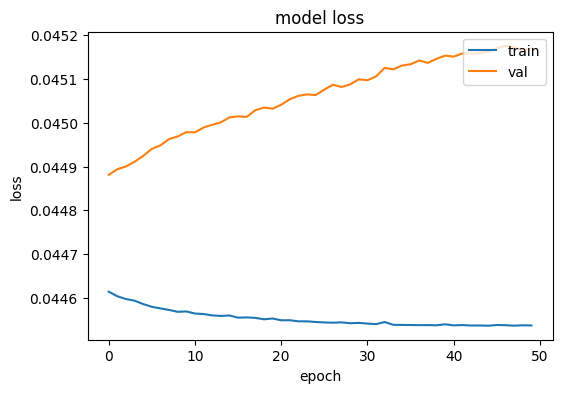

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history_dec1.history['loss'])
plt.plot(history_dec1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# **FULL TOF**

In [ ]:
REFERENCE_PULSE_dec0 = np.tile(new_V55[0,:,0], (new_V82.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(new_V55[0,:,1], (new_V82.shape[0],2,1)).swapaxes(1,2)

In [ ]:
test_dec0_V28 = np.stack((REFERENCE_PULSE_dec0[:new_V28.shape[0],:,0],new_V28[:,:,0]),axis=2)
test_dec1_V28 = np.stack((REFERENCE_PULSE_dec1[:new_V28.shape[0],:,0],new_V28[:,:,1]),axis=2)
test_dec0_V55 = np.stack((REFERENCE_PULSE_dec0[:new_V55.shape[0],:,0],new_V55[:,:,0]),axis=2)
test_dec1_V55 = np.stack((REFERENCE_PULSE_dec1[:new_V55.shape[0],:,0],new_V55[:,:,1]),axis=2)
test_dec0_V82 = np.stack((REFERENCE_PULSE_dec0[:new_V82.shape[0],:,0],new_V82[:,:,0]),axis=2)
test_dec1_V82 = np.stack((REFERENCE_PULSE_dec1[:new_V82.shape[0],:,0],new_V82[:,:,1]),axis=2)

6/6 [==============================] - 0s 2ms/step

V82: CENTROID(ns) = -0.053  FWHM(ns) = 0.017  std(ns) = 0.075
V55: CENTROID(ns) = -0.052  FWHM(ns) = 0.018  std(ns) = 0.108
V28: CENTROID(ns) = -0.054  FWHM(ns) = 0.017  std(ns) = 0.025


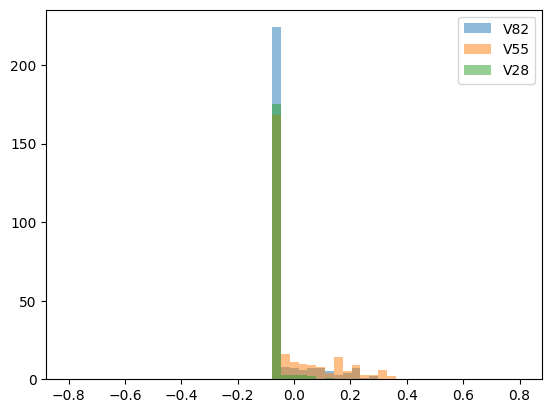

In [ ]:
TOFN_dec0_REF_V82 = model_dec0.predict(test_dec0_V82)
TOFN_dec1_REF_V82 = model_dec1.predict(test_dec1_V82)
TOFN_dec0_REF_V55 = model_dec0.predict(test_dec0_V55)
TOFN_dec1_REF_V55 = model_dec1.predict(test_dec1_V55)
TOFN_dec0_REF_V28 = model_dec0.predict(test_dec0_V28)
TOFN_dec1_REF_V28 = model_dec1.predict(test_dec1_V28)


TOFN_V82 = TOFN_dec0_REF_V82-TOFN_dec1_REF_V82
TOFN_V55 = TOFN_dec0_REF_V55-TOFN_dec1_REF_V55
TOFN_V28 = TOFN_dec0_REF_V28-TOFN_dec1_REF_V28


#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(-1*TOFN_V82 + np.mean(TOFN_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*TOFN_V55 + np.mean(TOFN_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*TOFN_V28 + np.mean(TOFN_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, np.std(TOFN_V82)))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, np.std(TOFN_V55)))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, np.std(TOFN_V28)))

# **MULTIPLE TRAINING**

In [ ]:
Ntries= 30

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []


directory = '/home/josea/DEEP_TIMING/convolucional'

for i in range(Ntries):
  model_dec0 = model_definition(Nt_new)
  model_dec1 = model_definition(Nt_new)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate=1e-4)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate=1e-4)

  model_dec0.compile(optimizer=opt_dec0,loss='MSE')
  model_dec1.compile(optimizer=opt_dec1,loss='MSE')

  history_dec0 = model_dec0.fit(trainX_dec0, REF_train_dec0, epochs=125, validation_data=(valX_dec1,REF_val_dec1),verbose=0)
  history_dec1 = model_dec1.fit(trainX_dec1, REF_train_dec1, epochs=125, validation_data=(valX_dec1,REF_val_dec1),verbose=0)

  TOFN_dec0_REF_V82 = model_dec0.predict(test_dec0_V82)
  TOFN_dec1_REF_V82 = model_dec1.predict(test_dec1_V82)
  TOFN_dec0_REF_V55 = model_dec0.predict(test_dec0_V55)
  TOFN_dec1_REF_V55 = model_dec1.predict(test_dec1_V55)
  TOFN_dec0_REF_V28 = model_dec0.predict(test_dec0_V28)
  TOFN_dec1_REF_V28 = model_dec1.predict(test_dec1_V28)


  TOFN_V82 = TOFN_dec0_REF_V82-TOFN_dec1_REF_V82
  TOFN_V55 = TOFN_dec0_REF_V55-TOFN_dec1_REF_V55
  TOFN_V28 = TOFN_dec0_REF_V28-TOFN_dec1_REF_V28

  TOFN_V28_list.append(TOFN_V28)
  TOFN_V55_list.append(TOFN_V55)
  TOFN_V82_list.append(TOFN_V82)

  model_dec0.save(directory + 'model_dec0_' + str(i) + '.h5')
  model_dec1.save(directory + 'model_dec1_' + str(i) + '.h5')


TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')


In [ ]:
for i in range(TOFN_V28_array.shape[0]):
  mean_std = (np.std(TOFN_V82_array[i,:]) + np.std(TOFN_V55_array[i,:]) + np.std(TOFN_V28_array[i,:])) / 3
  centroid_V28 = -1*np.mean(TOFN_V28_array[i,:]) + np.mean(TOFN_V55_array[i,:])
  centroid_V82 = -1*np.mean(TOFN_V82_array[i,:]) + np.mean(TOFN_V55_array[i,:])
  mean_error_centroid = np.sqrt((centroid_V28 + 0.2)**2 + (centroid_V82-0.2)**2)
  print('index: %d  %.3f %.3f ' % (i, mean_std, mean_error_centroid))


V82: CENTROID(ns) = 0.216  FWHM(ns) = 0.225  std(ns) = 0.088
V55: CENTROID(ns) = 0.005  FWHM(ns) = 0.197  std(ns) = 0.083
V28: CENTROID(ns) = -0.189  FWHM(ns) = 0.184  std(ns) = 0.092


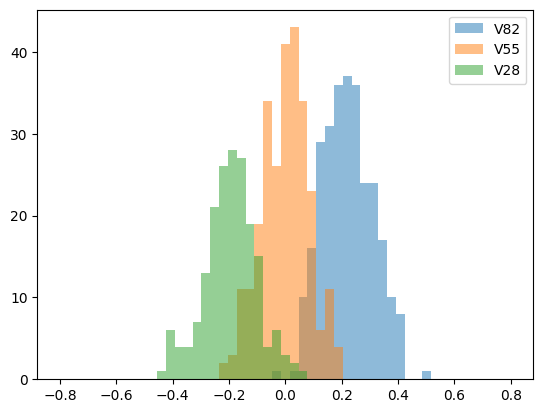

In [ ]:
index = 37
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(-1*(TOFN_V82_array[index]) + np.mean(TOFN_V55_array[index]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*(TOFN_V55_array[index]) + np.mean(TOFN_V55_array[index]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*(TOFN_V28_array[index]) + np.mean(TOFN_V55_array[index]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, np.std(TOFN_V82_array[index])))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, np.std(TOFN_V55_array[index])))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, np.std(TOFN_V28_array[index])))